# Data Science Trainee Hands On

## Pendahuluan

### Latar Belakang

Sejak beberapa tahun ke belakang, media sosial menjadi salah satu media penyebaran informasi terbesar yang digunakan di masyarakat. Media sosial memberikan ruang untuk setiap individu dapat melakukan produksi, distribusi, dan konsumsi informasi dengan sangat mudah tanpa mengenal ruang dan waktu. Kemudahan dalam menyampaikan informasi dan berekspresi membuat volume data media sosial menjadi sangat besar. Data ini menyimpan berbagai informasi yang berharga. Salah satu penggunaan media sosial dalam di dalam masyarakat sebagai media diskusi atau sekedar penyampaian opini tentang berbagai isu yang berkembang di masyarakat. 

Kemudahan yang dihadirkan media sosial tidak hanya memberikan dampak yang bersifat positif. Salah satu hal yang paling mudah terlihat adalah mudahnya seseorang untuk melakukan ujaran kebencian (hate speech) terhadap sesama pengguna di media sosial. Hal ini tentunya menjadi masalah yang cukup serius karena memungkinkan terciptanya lingkungan yang buruk bagi masyarakat ketika bermedia sosial. Bukan tidak mungkin banyaknya permasalahan mental yang dialami orang-orang tidak lepas dari kondisi ini. Kondisi ini juga tentunya sangat tidak sesuai dengan budaya Indonesia yang terkenal akan keramahannya antar sesama. Terpisahnya jarak dan tempat yang dihubungkan oleh media sosial rasanya membuat hilangnya budaya masyarakat Indonesia yang selalu sopan dan santun kepada siapa pun.

Efek negatif yang ditimbulkan oleh teknologi seharusnya dapat diatasi oleh pendekatan teknologi pula. Salah satu solusi untuk mengurangi keberadaan ujaran kebencian dan bullying di media sosial adalah dengan melakukan klasifikasi atas pesan yang diterima untuk meniadakan pesan yang diduga mengandung maksud tertentu. Oleh karena itu, permasalahan yang dianalisis dan dicari solusinya pada implementasi ini adalah klasifikasi ujaran kebencian.

Sebelum melakukan pekerjaan utama, dilakukan analisis data teks mengenai topik ini terlebih dahulu. Analisis data dimaksudkan untuk mendapatkan wawasan/insight mengenai data yang dapat membantu dalam menyelesaikan masalah. Analisis dilakukan dengan mengolah data dan juga melakukan visualisasi terhadapnya.

### Deskripsi Permasalahan

Data yang digunakan memiliki 6 label dengan 5 label hate speech (**religion, race, physical, gender, other**) dan 1 label **not hate speech**. Pada implementasinya saya bermaksud untuk menganalisis terlebih dahulu dan akan menentukan apakah akan menggunakan 6 label atau diturunkan menjadi 2 label. 

Data yang digunakan merupakan kumpulan tweet yang memiliki label abusive dan hate speech. Untuk hate speech sendiri memiliki informasi lebih dalam terkait topik atau ranah hate speech-nya dan juga kekuatan dari hate speech-nya. Pada folder dataset juga disediakan kamus typo atau slangword sebagai upaya normalisasi teks tweet yang banyak mengandung kata typo, singkatan, dan gaul. Terdapat juga list kata abusive yang dapat digunakan untuk ekstraksi fitur.


## Data Overview

### Data Preparation

#### Import Pustaka

In [5]:
%matplotlib inline 

import re
import string
import nltk
import pickle
import warnings

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

from nltk.corpus import wordnet
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from wordcloud import WordCloud
from spacy.lang.id.stop_words import STOP_WORDS as STOPWORDS

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

In [6]:
sns.set_style("white")
pd.options.mode.chained_assignment = None
pd.set_option('display.max_colwidth', None)
warnings.simplefilter(action="ignore", category=FutureWarning)

#### Import Data

In [7]:
df_raw = pd.read_csv("./dataset/data.csv", encoding = "ISO-8859-1")
df_raw.head(3)

,Tweet,HS,Abusive,HS_Individual,HS_Group,HS_Religion,HS_Race,HS_Physical,HS_Gender,HS_Other,HS_Weak,HS_Moderate,HS_Strong
0,- disaat semua cowok berusaha melacak perhatian gue. loe lantas remehkan perhatian yg gue kasih khusus ke elo. basic elo cowok bego ! ! !',1,1,1,0,0,0,0,0,1,1,0,0
1,RT USER: USER siapa yang telat ngasih tau elu?edan sarap gue bergaul dengan cigax jifla calis sama siapa noh licew juga',0,1,0,0,0,0,0,0,0,0,0,0
2,"41. Kadang aku berfikir, kenapa aku tetap percaya pada Tuhan padahal aku selalu jatuh berkali-kali. Kadang aku merasa Tuhan itu ninggalkan aku sendirian. Ketika orangtuaku berencana berpisah, ketika kakakku lebih memilih jadi Kristen. Ketika aku anak ter",0,0,0,0,0,0,0,0,0,0,0,0


Untuk mempermudah analisis, label yang berbentuk one hot encoding ditranslasikan menjadi bentuk label text. 

In [8]:
def categories_translate(row):
    if (row.HS_Religion):
        return "religion hatespeech"
    elif (row.HS_Race):
        return "race hatespeech"
    elif (row.HS_Physical):
        return "physical hatespeech"
    elif (row.HS_Gender):
        return "gender hatespeech"
    elif (row.HS_Other):
        return "other hatespeech"
    else:
        return "not hatespeech"
    
def target_translate(row):
    if (row.HS_Individual):
        return "individual hatespeech"
    elif (row.HS_Group):
        return "group hatespeech"
    else:
        return "not hatespeech"
    
def severity_translate(row):
    if (row.HS_Weak):
        return "weak hatespeech"
    elif (row.HS_Moderate):
        return "moderate hatespeech"
    elif (row.HS_Strong):
        return "strong hatespeech"
    else:
        return "not hatespeech"

In [9]:
df_raw["hate_speech"] = df_raw.apply(lambda row: "hatespeech" if row.HS else "not hatespeech", axis=1)
df_raw["abusive"] = df_raw.apply(lambda row: "abusive" if row.HS else "not abusive", axis=1)
df_raw["hate_speech_categories"] = df_raw.apply(lambda row: categories_translate(row), axis=1)
df_raw["hate_speech_target"] = df_raw.apply(lambda row: target_translate(row), axis=1)
df_raw["hate_speech_severity"] = df_raw.apply(lambda row: severity_translate(row), axis=1)

df_raw = df_raw.rename(columns={"Tweet": "text"})
df_raw = df_raw.loc[:, ['text', 'hate_speech', "abusive", "hate_speech_categories", "hate_speech_target", "hate_speech_severity"]]

Teramati bahwa data masih sangat kotor karena diambil dari media sosial sehingga masih memiliki mention, hashtag, hingga url. Diperlukan preprocessing untuk menangani ini.

#### Missing Values

In [10]:
df_raw.isnull().sum()

text                      0
hate_speech               0
abusive                   0
hate_speech_categories    0
hate_speech_target        0
hate_speech_severity      0
dtype: int64

Tidak terdapat baris data yang memiliki nilai null atau tidak terdefinisi sehingga dapat diproses keseluruhannya.

#### Duplicate Values

In [11]:
df_raw[df_raw.duplicated(keep=False)]

,text,hate_speech,abusive,hate_speech_categories,hate_speech_target,hate_speech_severity
33,"RT USER: Kelakuan homok jaman now, ngentot aja sambil live di Blued #gayvid #gvid #lokalhangat URL",not hatespeech,not abusive,not hatespeech,not hatespeech,not hatespeech
40,GAPERNAH MENDALAMI AL-QURAN YA BANG??? PANTESAN MULUTNYA KAYA ORANG KAFIR BEJAT HINA farhatabbaslaw',hatespeech,abusive,religion hatespeech,individual hatespeech,weak hatespeech
43,"#GubernurZamanNow #GusIpulPuti2 #GanjarYasin1 #DjarotSihar2 #HasanAnton2 #KosterAce1 #NurdinSudirman3 #KarolinGidot2 RT USER: ""Keanekaragaman budaya, suku, agama, itulah sesungguhnya kekayaan kita,â?? tutur Djarot di hadapan peserta Rakercabsuâ?¦",not hatespeech,not abusive,not hatespeech,not hatespeech,not hatespeech
165,"Giat Bhabinkamtibmas Brigpol Mbs Sihombing pd hari ini, Rabu 11 April 2018 melaks sambang desa dan tatap muka sekaligus monitoring Kamtibmas menuju Pilkada 2018 di Desa Lobusiregar I, tepatnya dirumah Rudi Panjaitan, Helman Siahaan dan Hotman Siahaan",not hatespeech,not abusive,not hatespeech,not hatespeech,not hatespeech
182,USER USER USER USER USER USER USER USER USER USER USER USER USER USER USER USER USER USER USER USER USER,not hatespeech,not abusive,not hatespeech,not hatespeech,not hatespeech
...,...,...,...,...,...,...
12793,I added a video to a USER playlist,not hatespeech,not abusive,not hatespeech,not hatespeech,not hatespeech
12952,USER USER USER USER USER USER USER USER USER USER USER USER USER USER USER USER USER USER USER USER USER,not hatespeech,not abusive,not hatespeech,not hatespeech,not hatespeech
12953,"SETUJU SAYA,KLAU AHOK DAPAT GELAR SANTRI KEHORMATAN.... TAPI SANTRI KEHORMATAN BABI.... URL",hatespeech,abusive,other hatespeech,individual hatespeech,weak hatespeech
12985,USER ahmad dhani yang terhormat paling babi paling anjing aing kontol paling lonte tungu saat nya karier mu akan habis!!!!,hatespeech,abusive,gender hatespeech,individual hatespeech,weak hatespeech


Data duplikat dihapus karena jumlahnya tidak terlalu signifikan

In [12]:
df_raw = df_raw[df_raw["text"] != ""]
df_raw = df_raw.drop_duplicates().reset_index()

### Preprocessing
Method preprocessing digunakan untuk mentransformasikan teks pesan dari media sosial menjadi lebih bersih dan tidak lagi mengandung entitas yang kurang diperlukan. Beberapa hal yang dilakukan adalah :
- Lowercasing
- Hapus URL, mention, Hashtag
- Hapus STOPWORDS atau kata yang sangat sering muncuk dan tidak perlu
- Hapus selain huruf sehingga vektor nanti hanya terdiri dari kata

In [13]:
from nltk.corpus import wordnet
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

STOPWORDS.update(["saya", "user", "url", "yg", "lo", "ya", "rt", "aja", "nya", "ga", "gak", "orang"])

def show_wordcloud(data):
    words = ''
     
    for sentence in data:
        tokens = str(sentence).split()
        for i in range(len(tokens)):
            tokens[i] = tokens[i].lower()
        words += " ".join(tokens) + " "
     
    wordcloud = WordCloud(width = 800, height = 800, background_color ='white', min_font_size = 12, stopwords=STOPWORDS).generate(words)
     
    plt.figure(figsize = (8, 8), facecolor = None)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.tight_layout(pad = 0)
     
    plt.show()
    
def show_top_ngram(df_column):
    
    vectorizer = TfidfVectorizer(ngram_range=(2,2))

    ngrams = vectorizer.fit_transform(df_column)
    count_values = ngrams.toarray().sum(axis=0)
    vocab = vectorizer.vocabulary_
    df_ngram = pd.DataFrame(sorted([(count_values[i],k) for k,i in vocab.items()], reverse=True)).rename(columns={0: 'frequency', 1:'bigram/trigram'})

    return df_ngram

def delete_url(text):
    links = re.findall(re.compile('((https?):((//)|(\\\\))+([\w\d:#@%/;$()~_?\+-=\\\.&](#!)?)*)', re.DOTALL), text)
    for link in links:
        text = text.replace(link[0], ' ')    
    return text

def delete_mention_tag(text):
               
    # filter kata yang mengandung penanda mention dan hashtag
    words = []
    for word in text.split():
        word = word.strip()
        if word:
            if word[0] not in ['@','#']:
                words.append(word)
    return ' '.join(words)

def preprocessing(text):
    text = text.lower()                    # convert ke lowercase
    text = delete_url(text)                # hapus URL/link
    text = delete_mention_tag(text)        # hapus entitas mention dan hashtags
    text = text.strip()
    text = " ".join([word for word in text.split() if not word in set(['lo', 'yg', 'saya', 'user', 'url'])]) 
    text = re.sub(r" \d+ ", " ", text)     # hapus digit
    text = text.translate(str.maketrans("", "", string.punctuation))
    text = re.sub(r"[^a-z ]", "", text)
    text = re.sub(r"  ", " ", text)
    return text

In [14]:
df_raw['text'] = df_raw.apply(lambda row: preprocessing(row.text), axis=1)

## Eksperimen Model

In [15]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler

from sklearn.metrics import classification_report
from sklearn.metrics import PrecisionRecallDisplay
from sklearn.metrics import ConfusionMatrixDisplay

from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier

from xgboost import XGBClassifier

### Pendefinisian Kelas Pipeline
Dikarenakan diperlukan preprocessing pada text input sebelum di-encoding, maka dibuat kelas baru yang fungsinya mirip dengan fungsi pipeline dari sklearn. Objek dari kelas ini nantinya akan menjadi model yang disimpan untuk deployment karena sudah termasuk preprocessing text dan juga sekaligus menyimpan berbagai model pemrosesan seperti sampling, vectorizer, encoder, hingga classifier.

In [16]:
from sklearn.metrics import classification_report
from sklearn.metrics import PrecisionRecallDisplay
from sklearn.metrics import ConfusionMatrixDisplay

class ModelPipeline:
    def __init__(self, imbalance_handler, vectorizer, encoder, classifier):
        self.imbalance_handler = imbalance_handler
        self.vectorizer = vectorizer
        self.encoder = encoder
        self.classifier = classifier
        
    def encoder(self):
        return self.encoder
    
    def fit(self, X_train, y_train):
        X_train, y_train = self.imbalance_handler.fit_resample(X_train, y_train)
        
        self.vectorizer.fit(X_train['text'].values)
        X_train = self.vectorizer.transform(X_train['text'].values)
        
        self.encoder.fit(y_train)
        y_train = pd.DataFrame(self.encoder.transform(y_train.values.ravel()))
    
        return self.classifier.fit(X_train, y_train.values.ravel())
    
    def predict(self, X_test):
        X_test['text'] = X_test.apply(lambda row: preprocessing(row.text), axis=1)
        X_test = self.vectorizer.transform(X_test['text'].values)
        return self.classifier.predict(X_test)
    
    def predict_proba(self, X_test):
        X_test['text'] = X_test.apply(lambda row: preprocessing(row.text), axis=1)
        X_test = self.vectorizer.transform(X_test['text'].values)
        return self.classifier.predict_proba(X_test)[:, 1]
    
    def classification_report(self, y_test, y_pred):
        y_test = pd.DataFrame(self.encoder.transform(y_test))
        return classification_report(y_test, y_pred, target_names=self.encoder.classes_)
    
    def precision_recall_curve(self, y_test, y_pred):
        y_test = pd.DataFrame(self.encoder.transform(y_test))
        display = PrecisionRecallDisplay.from_predictions(
            y_test, y_pred, name="NaiveBayes", ax = plt.gca()
        )
        res = display.ax_.set_title("Precision-Recall Curve")
        return res
    
    def confusion_matrix_display(self, y_test, y_pred):
        y_test = pd.DataFrame(self.encoder.transform(y_test))
        
        fig, axn = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(16, 8))
        
        display = ConfusionMatrixDisplay.from_predictions(y_test, y_pred, ax=axn[0], cmap=plt.cm.Blues, normalize=None, display_labels=self.encoder.classes_, xticks_rotation='vertical')
        display.ax_.set_title("Confusion Matrix Non Normalized")
        
        display = ConfusionMatrixDisplay.from_predictions(y_test, y_pred, ax=axn[1], cmap=plt.cm.Blues, normalize='true', display_labels=self.encoder.classes_, xticks_rotation='vertical')
        display.ax_.set_title("Confusion Matrix Normalized")
        
        plt.show();

### Splitting Data

In [17]:
from sklearn.model_selection import train_test_split

df_raw = df_raw[df_raw["hate_speech_categories"] != "not hatespeech"]

X = df_raw[["text"]]
y = df_raw['hate_speech_categories']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=11)

### Perbandingan Vectorizer berbasis TF-IDF dan Count Frekuensi
**TF-IDF** adalah algoritma yang berguna untuk menghitung bobot setiap kata yang digunakan dalam klasifikasi sehingga didapatkan bobot yang merepresentasikan kata penting dalam klasifikasi. Konsepnya adalah dengan melakukan perbandingan term frequency dengan inverse dari document frequency. Kata yang penting untuk klasifikasi seharusnya cukup banyak muncul tapi tidak muncul hampir di semua data. Ini yang membuat TF-IDF menjadi powerful karena dapat menyingkirkan kata yang hampir setiap data muncul dan mengurangi kata yang kurang dapat menjadi pembeda. Sedangkan algoritma CountVectorizer hanya berbasiskan frekuensi saja.

Untuk memastikan bahwa filtering yang dilakukan TF-IDF dilakukan eksperimen perbandingan performa dengan  model yang berbeda.

#### Model TF-IDF

                     precision    recall  f1-score   support

  gender hatespeech       0.49      0.70      0.58        27
   other hatespeech       0.92      0.73      0.81       367
physical hatespeech       0.42      0.69      0.52        26
    race hatespeech       0.61      0.90      0.73        51
religion hatespeech       0.62      0.79      0.69        81

           accuracy                           0.75       552
          macro avg       0.61      0.76      0.67       552
       weighted avg       0.80      0.75      0.76       552



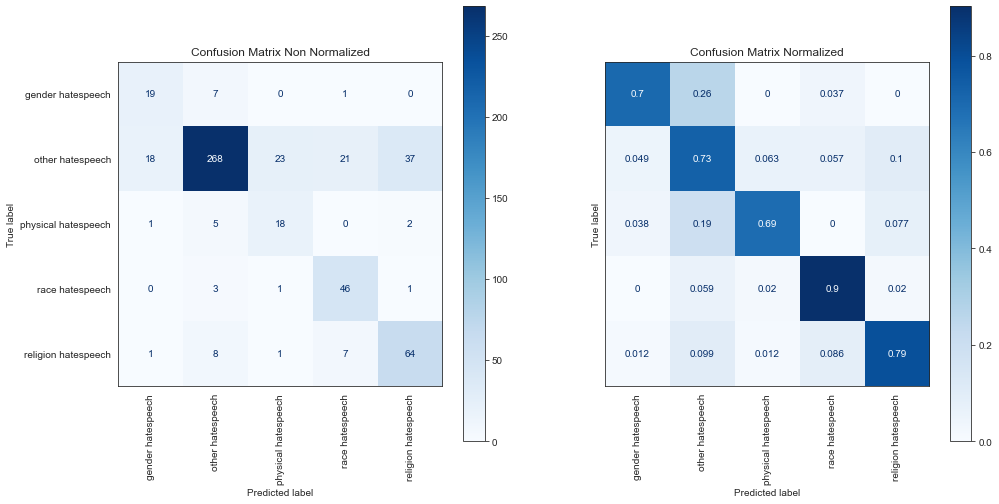

In [18]:
pipeline = ModelPipeline(RandomUnderSampler(), TfidfVectorizer(max_features=1000), LabelEncoder(), RandomForestClassifier(max_depth=5))
pipeline.fit(X_train, y_train)

y_pred = pipeline.predict(X_test)

print(pipeline.classification_report(y_test, y_pred))
pipeline.confusion_matrix_display(y_test, y_pred);

#### Model Count Frequency

                     precision    recall  f1-score   support

  gender hatespeech       0.30      0.74      0.43        27
   other hatespeech       0.91      0.72      0.81       367
physical hatespeech       0.58      0.54      0.56        26
    race hatespeech       0.56      0.90      0.69        51
religion hatespeech       0.68      0.74      0.71        81

           accuracy                           0.74       552
          macro avg       0.61      0.73      0.64       552
       weighted avg       0.80      0.74      0.75       552



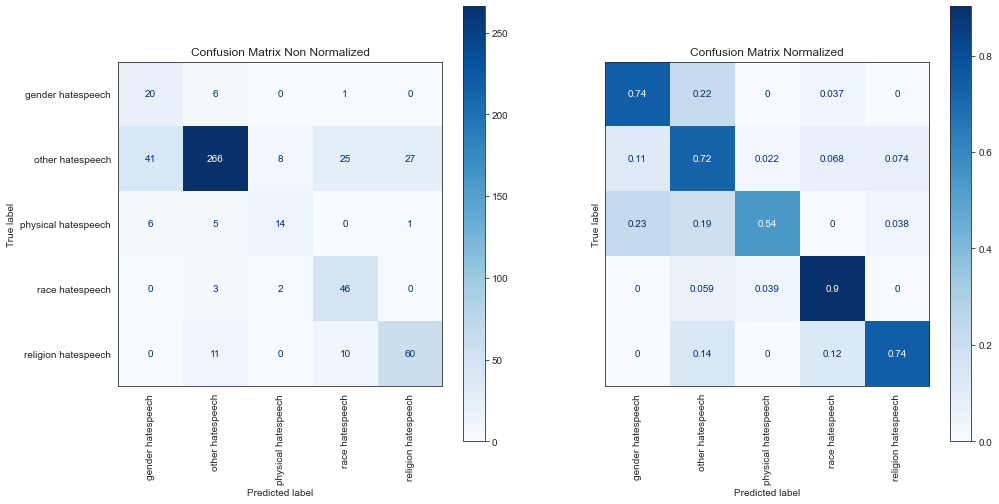

In [19]:
pipeline = ModelPipeline(RandomUnderSampler(), CountVectorizer(max_features=1000), LabelEncoder(), RandomForestClassifier(max_depth=5))
pipeline.fit(X_train, y_train)

y_pred = pipeline.predict(X_test)

print(pipeline.classification_report(y_test, y_pred))
pipeline.confusion_matrix_display(y_test, y_pred);

Terlihat bahwa walau dalam perbedaan yang cenderung kecil, namun ada efek yang diberikan TF-IDF sehingga selanjutnya vectorizer yang digunakan adalah TF-IDF.

### Perbandingan Handling Imbalance berbasis Undersample dan Oversample
Untuk menentukan teknik terbaik untuk mengatasi data yang tidak seimbang rasionya, dibuat 2 model sebagai pembanding.

#### Model Oversample

                     precision    recall  f1-score   support

  gender hatespeech       0.43      0.74      0.55        27
   other hatespeech       0.91      0.78      0.84       367
physical hatespeech       0.73      0.62      0.67        26
    race hatespeech       0.57      0.90      0.70        51
religion hatespeech       0.69      0.75      0.72        81

           accuracy                           0.78       552
          macro avg       0.67      0.76      0.70       552
       weighted avg       0.81      0.78      0.79       552



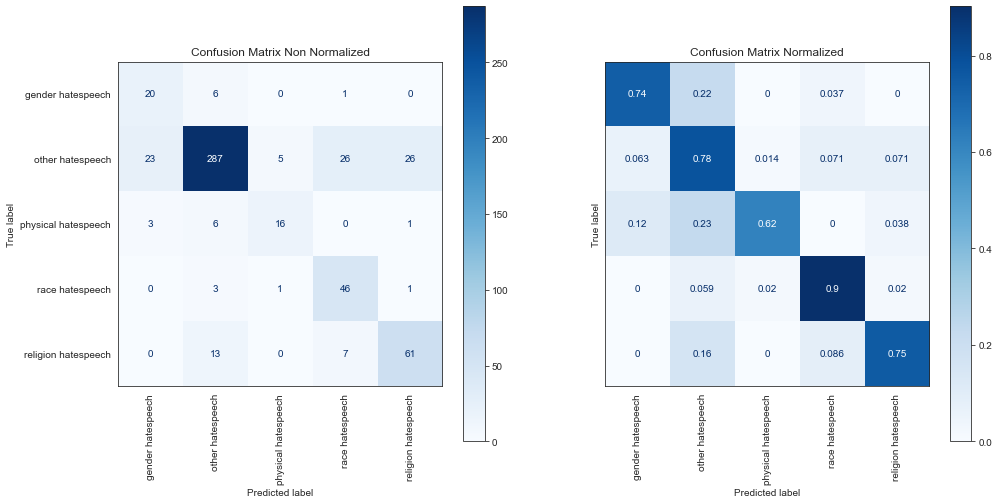

In [36]:
pipeline = ModelPipeline(RandomOverSampler(), TfidfVectorizer(max_features=1000), LabelEncoder(), RandomForestClassifier(max_depth=3))
pipeline.fit(X_train, y_train)

y_pred = pipeline.predict(X_test)

print(pipeline.classification_report(y_test, y_pred))
pipeline.confusion_matrix_display(y_test, y_pred);

#### Model Undersample

                     precision    recall  f1-score   support

  gender hatespeech       0.45      0.67      0.54        27
   other hatespeech       0.92      0.81      0.86       367
physical hatespeech       0.53      0.65      0.59        26
    race hatespeech       0.65      0.92      0.76        51
religion hatespeech       0.70      0.72      0.71        81

           accuracy                           0.79       552
          macro avg       0.65      0.75      0.69       552
       weighted avg       0.82      0.79      0.80       552



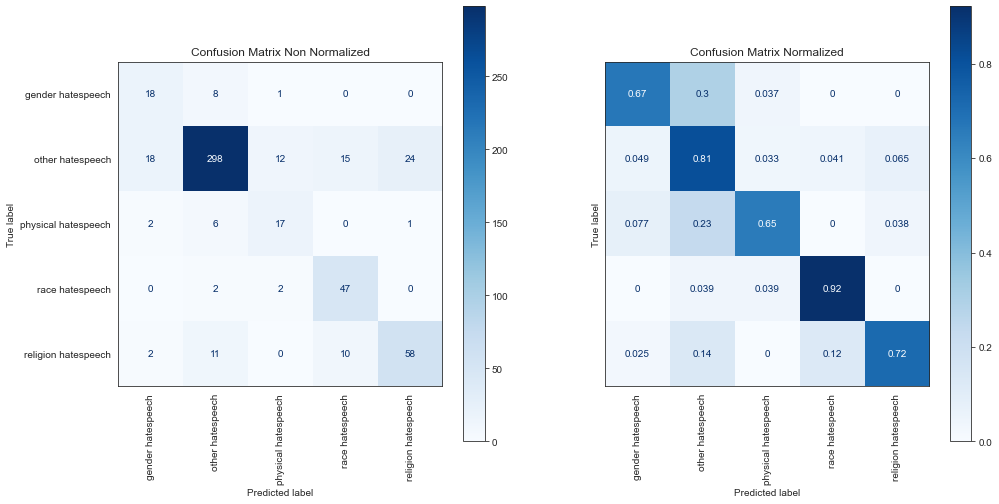

In [39]:
pipeline = ModelPipeline(RandomUnderSampler(), TfidfVectorizer(max_features=1000), LabelEncoder(), RandomForestClassifier(max_depth=3))
pipeline.fit(X_train, y_train)

y_pred = pipeline.predict(X_test)

print(pipeline.classification_report(y_test, y_pred))
pipeline.confusion_matrix_display(y_test, y_pred);

Oversampling mendapatkan performa yang lebih baik, mungkin dikarenakan jumlah kata kelas minoritas yang cenderung sangat sedikit. 

### Perbandingan Basis 1-grams dan 2-grams
Salah satu alternatif representasi encoding untuk pembelajaran mesin adalah bigram atau n-grams. Untuk melihat pengaruhnya, coba dibandingkan antara representasi kata dan bigram

#### Model Kata

                     precision    recall  f1-score   support

  gender hatespeech       0.45      0.70      0.55        27
   other hatespeech       0.92      0.77      0.84       367
physical hatespeech       0.46      0.69      0.55        26
    race hatespeech       0.61      0.90      0.72        51
religion hatespeech       0.65      0.72      0.68        81

           accuracy                           0.77       552
          macro avg       0.62      0.76      0.67       552
       weighted avg       0.81      0.77      0.78       552



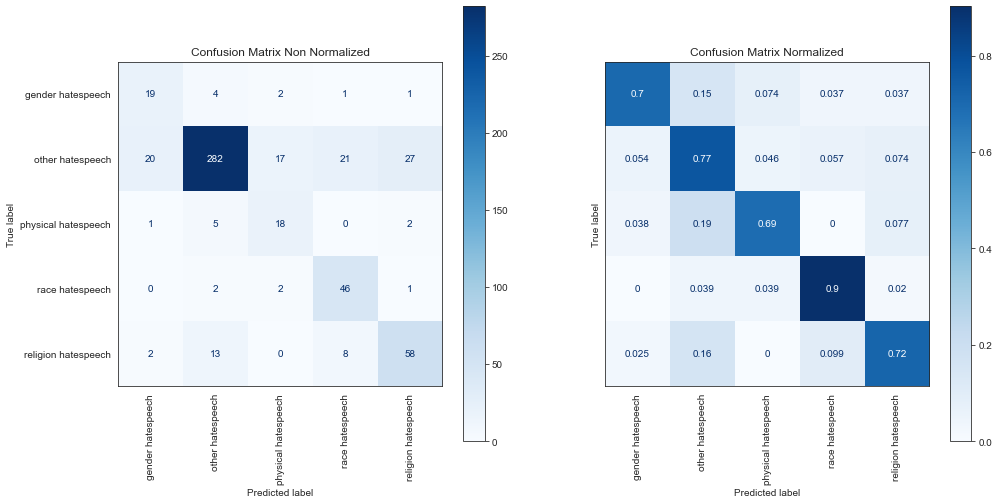

In [40]:
pipeline = ModelPipeline(RandomOverSampler(), TfidfVectorizer(max_features=2000, ngram_range=(1,1)), LabelEncoder(), RandomForestClassifier(max_depth=3))
pipeline.fit(X_train, y_train)

y_pred = pipeline.predict(X_test)

print(pipeline.classification_report(y_test, y_pred))
pipeline.confusion_matrix_display(y_test, y_pred);

#### Model Bigram

                     precision    recall  f1-score   support

  gender hatespeech       0.67      0.07      0.13        27
   other hatespeech       0.73      0.96      0.83       367
physical hatespeech       0.50      0.04      0.07        26
    race hatespeech       0.76      0.37      0.50        51
religion hatespeech       0.67      0.35      0.46        81

           accuracy                           0.73       552
          macro avg       0.66      0.36      0.40       552
       weighted avg       0.71      0.73      0.67       552



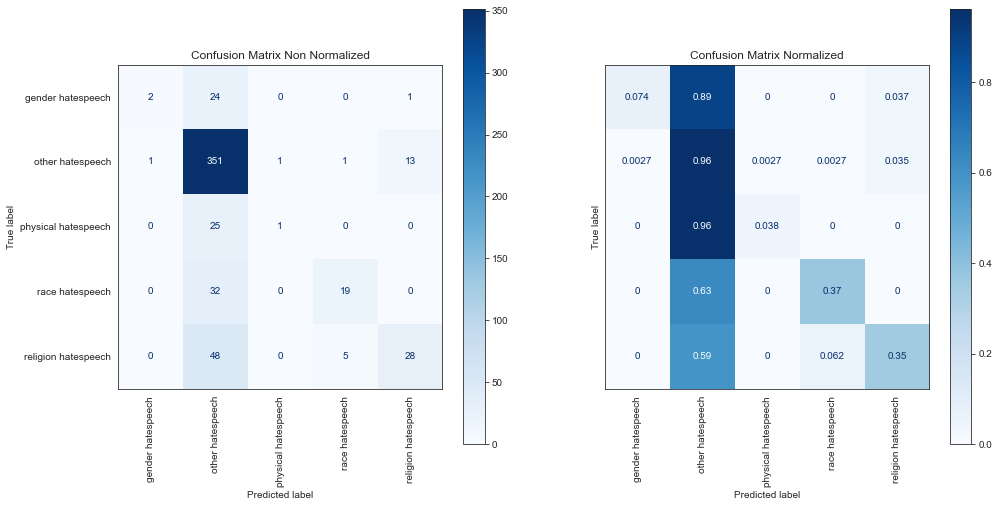

In [41]:
pipeline = ModelPipeline(RandomOverSampler(), TfidfVectorizer(max_features=2000, ngram_range=(2,2)), LabelEncoder(), RandomForestClassifier(max_depth=3))
pipeline.fit(X_train, y_train)

y_pred = pipeline.predict(X_test)

print(pipeline.classification_report(y_test, y_pred))
pipeline.confusion_matrix_display(y_test, y_pred);

Terlihat bahwa untuk kasus pendeteksian *topik hate speech* masih jauh lebih baik menggunakan basis kata dibandingkan bigram. Skor F1 untuk setiap kelas unggul pada representasi kata. Hal ini mungkin karena pendeteksian hate speech masih lebih sensitif atas kata dibandingkan bigram yang mungkin sudah mengandung semantik atau kasus yang lebih detail.

Untuk itu untuk eksperimen selanjutnya akan menggunakan basis kata.

### Perbandingan Algoritma Pembelajaran Mesin

In [42]:
pipelines = dict()

#### Model Random Forest Classifier

                     precision    recall  f1-score   support

  gender hatespeech       0.44      0.74      0.56        27
   other hatespeech       0.92      0.74      0.82       367
physical hatespeech       0.44      0.62      0.52        26
    race hatespeech       0.62      0.88      0.73        51
religion hatespeech       0.59      0.74      0.66        81

           accuracy                           0.75       552
          macro avg       0.60      0.74      0.65       552
       weighted avg       0.79      0.75      0.76       552



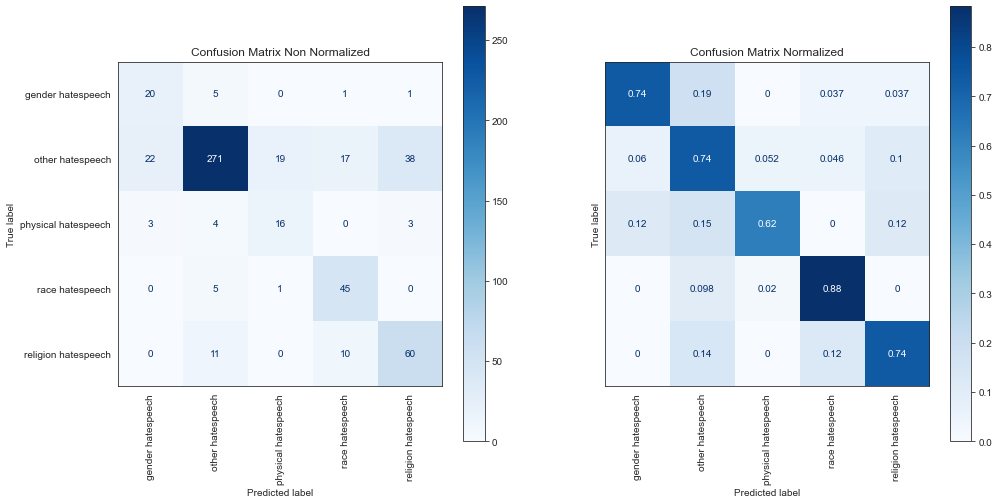

In [43]:
pipeline = ModelPipeline(RandomOverSampler(), TfidfVectorizer(max_features=4000, ngram_range=(1,1)), LabelEncoder(), RandomForestClassifier(max_depth=3))
pipeline.fit(X_train, y_train)
pipelines["RF"] = pipeline

y_pred = pipeline.predict(X_test)

print(pipeline.classification_report(y_test, y_pred))
pipeline.confusion_matrix_display(y_test, y_pred);

#### Naive Bayes Classifier

                     precision    recall  f1-score   support

  gender hatespeech       0.58      0.56      0.57        27
   other hatespeech       0.88      0.79      0.83       367
physical hatespeech       0.48      0.50      0.49        26
    race hatespeech       0.56      0.75      0.64        51
religion hatespeech       0.58      0.73      0.64        81

           accuracy                           0.75       552
          macro avg       0.62      0.66      0.63       552
       weighted avg       0.77      0.75      0.76       552



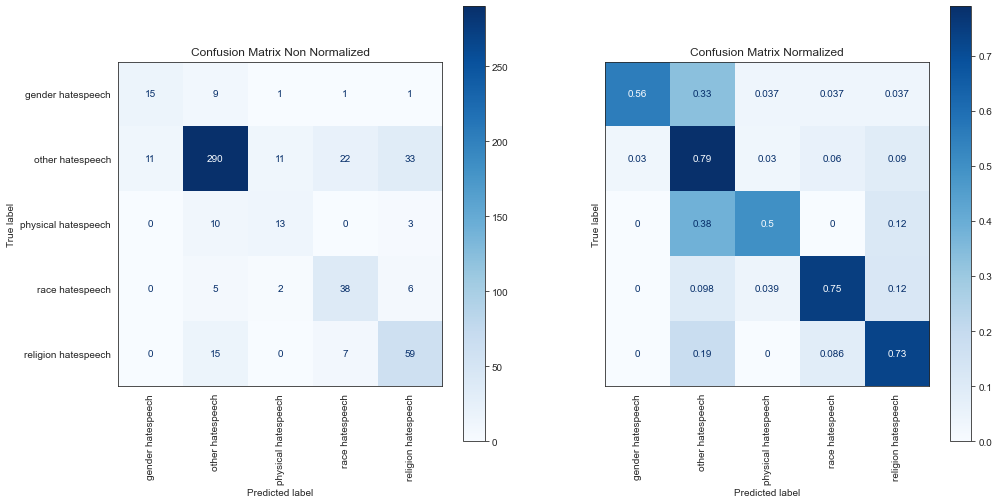

In [44]:
pipeline = ModelPipeline(RandomOverSampler(), TfidfVectorizer(max_features=4000, ngram_range=(1,1)), LabelEncoder(), MultinomialNB())
pipeline.fit(X_train, y_train)
pipelines["NB"] = pipeline

y_pred = pipeline.predict(X_test)

print(pipeline.classification_report(y_test, y_pred))
pipeline.confusion_matrix_display(y_test, y_pred);

#### Decision Tree Classifier

c:\Users\Legion\anaconda3\envs\tensorflow\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Legion\anaconda3\envs\tensorflow\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Legion\anaconda3\envs\tensorflow\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                     precision    recall  f1-score   support

  gender hatespeech       0.83      0.19      0.30        27
   other hatespeech       0.00      0.00      0.00       367
physical hatespeech       0.05      0.92      0.10        26
    race hatespeech       0.69      0.80      0.75        51
religion hatespeech       0.72      0.35      0.47        81

           accuracy                           0.18       552
          macro avg       0.46      0.45      0.32       552
       weighted avg       0.21      0.18      0.16       552



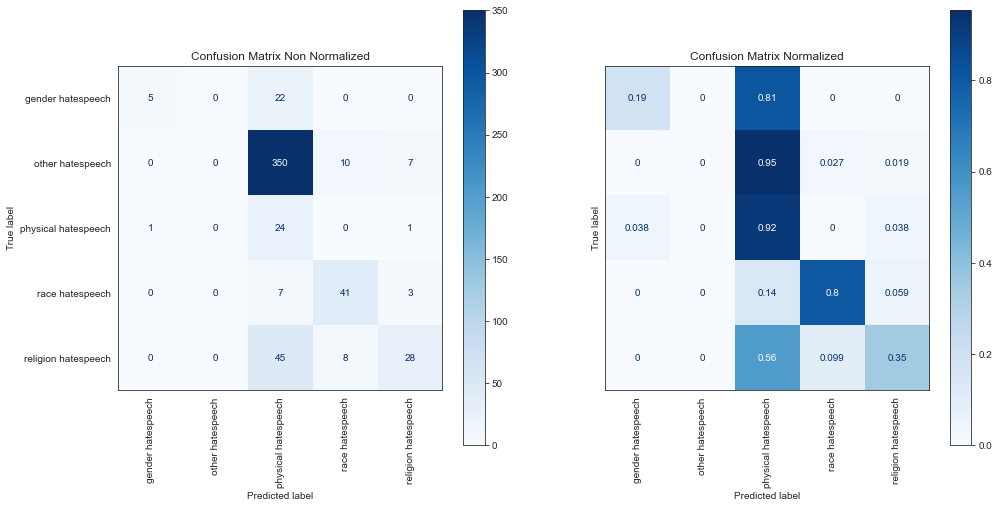

In [45]:
pipeline = ModelPipeline(RandomOverSampler(), TfidfVectorizer(max_features=4000, ngram_range=(1,1)), LabelEncoder(), DecisionTreeClassifier(max_depth=5))
pipeline.fit(X_train, y_train)
pipelines["DT"] = pipeline

y_pred = pipeline.predict(X_test)

print(pipeline.classification_report(y_test, y_pred))
pipeline.confusion_matrix_display(y_test, y_pred);

#### Neural Network MLP Classifier

                     precision    recall  f1-score   support

  gender hatespeech       0.92      0.41      0.56        27
   other hatespeech       0.84      0.92      0.88       367
physical hatespeech       0.75      0.35      0.47        26
    race hatespeech       0.73      0.65      0.69        51
religion hatespeech       0.68      0.70      0.69        81

           accuracy                           0.81       552
          macro avg       0.78      0.60      0.66       552
       weighted avg       0.81      0.81      0.80       552



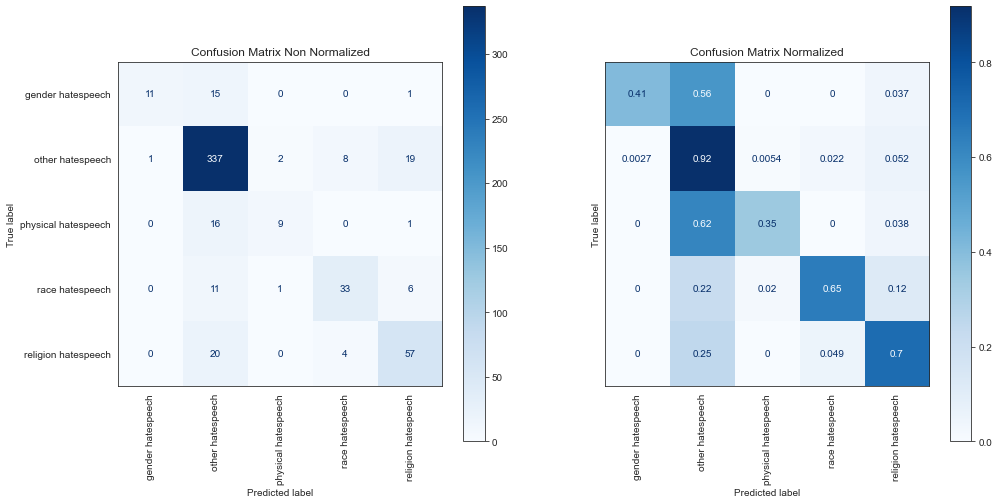

In [46]:
pipeline = ModelPipeline(RandomOverSampler(), TfidfVectorizer(max_features=4000, ngram_range=(1,1)), LabelEncoder(), MLPClassifier(solver='adam', max_iter=300, alpha=1e-5, hidden_layer_sizes=(30, 30), random_state=1))
pipeline.fit(X_train, y_train)
pipelines["MLP"] = pipeline

y_pred = pipeline.predict(X_test)

print(pipeline.classification_report(y_test, y_pred))
pipeline.confusion_matrix_display(y_test, y_pred);

#### kNN Classifier

                     precision    recall  f1-score   support

  gender hatespeech       1.00      0.19      0.31        27
   other hatespeech       0.71      0.99      0.82       367
physical hatespeech       1.00      0.15      0.27        26
    race hatespeech       0.90      0.18      0.30        51
religion hatespeech       0.76      0.20      0.31        81

           accuracy                           0.72       552
          macro avg       0.87      0.34      0.40       552
       weighted avg       0.76      0.72      0.65       552



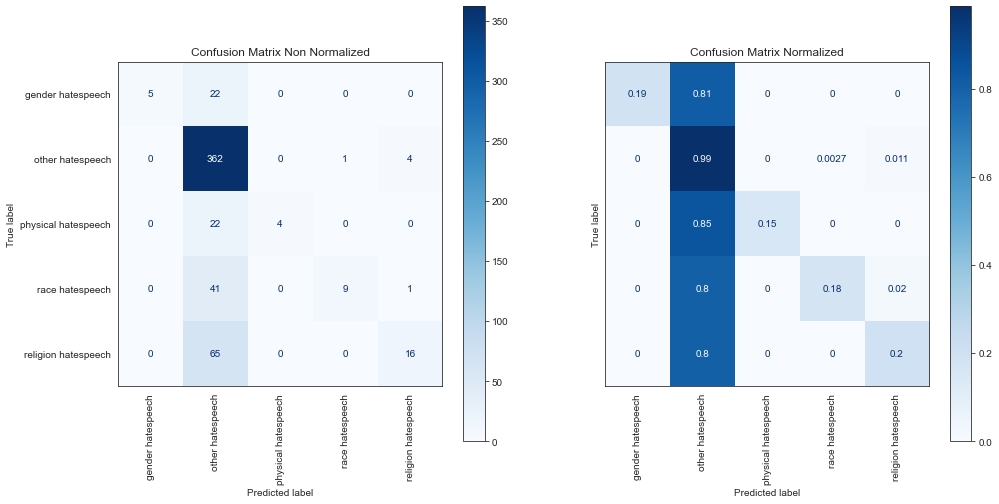

In [47]:
pipeline = ModelPipeline(RandomOverSampler(), TfidfVectorizer(max_features=4000, ngram_range=(1,1)), LabelEncoder(), KNeighborsClassifier(n_neighbors=2))
pipeline.fit(X_train, y_train)
pipelines["kNN"] = pipeline

y_pred = pipeline.predict(X_test)

print(pipeline.classification_report(y_test, y_pred))
pipeline.confusion_matrix_display(y_test, y_pred);

#### Logistic Regression Classifier

                     precision    recall  f1-score   support

  gender hatespeech       0.95      0.70      0.81        27
   other hatespeech       0.92      0.90      0.91       367
physical hatespeech       0.69      0.69      0.69        26
    race hatespeech       0.75      0.84      0.80        51
religion hatespeech       0.69      0.78      0.73        81

           accuracy                           0.86       552
          macro avg       0.80      0.78      0.79       552
       weighted avg       0.86      0.86      0.86       552



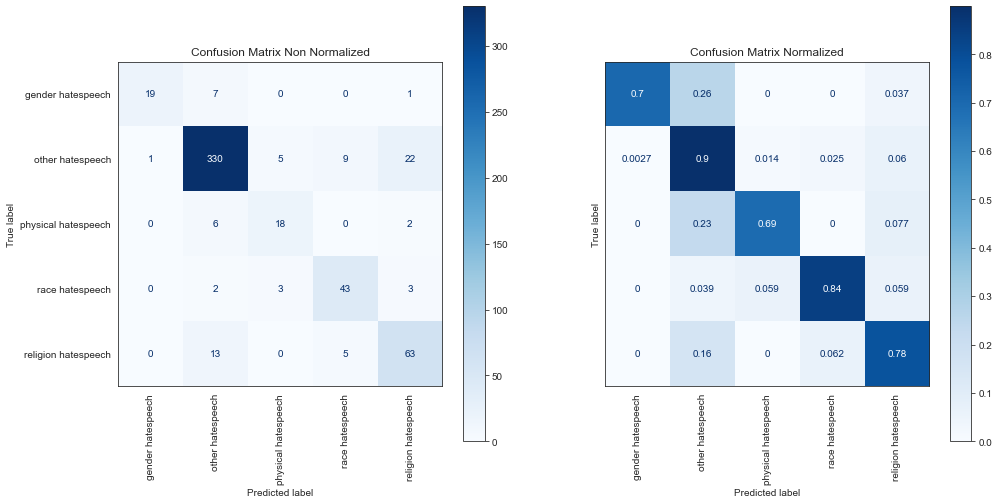

In [48]:
pipeline = ModelPipeline(RandomOverSampler(), TfidfVectorizer(max_features=4000, ngram_range=(1,1)), LabelEncoder(), LogisticRegression(solver='lbfgs', max_iter=2000))
pipeline.fit(X_train, y_train)
pipelines["LR"] = pipeline

y_pred = pipeline.predict(X_test)

print(pipeline.classification_report(y_test, y_pred))
pipeline.confusion_matrix_display(y_test, y_pred);

#### Linear SVM Classifier

                     precision    recall  f1-score   support

  gender hatespeech       0.90      0.70      0.79        27
   other hatespeech       0.91      0.89      0.90       367
physical hatespeech       0.71      0.65      0.68        26
    race hatespeech       0.76      0.80      0.78        51
religion hatespeech       0.66      0.75      0.70        81

           accuracy                           0.84       552
          macro avg       0.79      0.76      0.77       552
       weighted avg       0.85      0.84      0.84       552



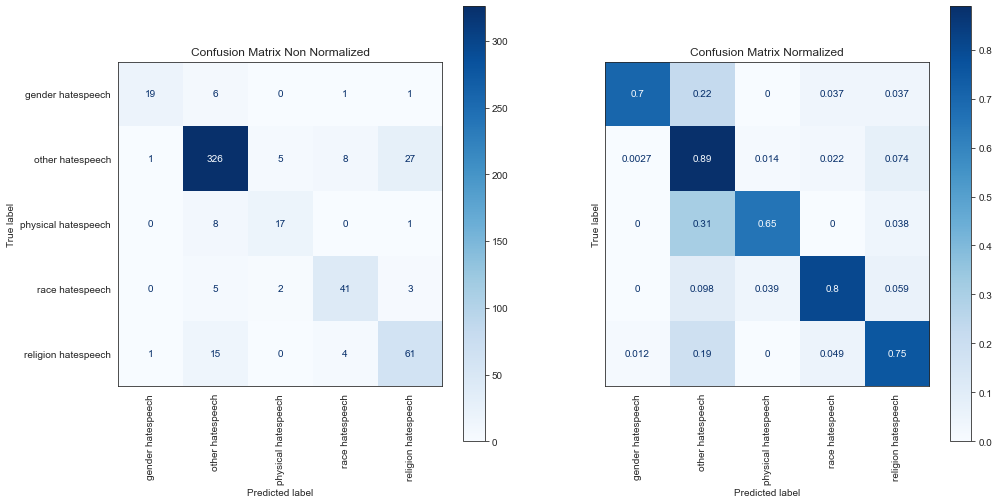

In [49]:
pipeline = ModelPipeline(RandomOverSampler(), TfidfVectorizer(max_features=4000, ngram_range=(1,1)), LabelEncoder(), LinearSVC(max_iter=10000))
pipeline.fit(X_train, y_train)
pipelines["SVM"] = pipeline

y_pred = pipeline.predict(X_test)

print(pipeline.classification_report(y_test, y_pred))
pipeline.confusion_matrix_display(y_test, y_pred);

#### XGBoost Classifier

                     precision    recall  f1-score   support

  gender hatespeech       0.91      0.78      0.84        27
   other hatespeech       0.91      0.90      0.91       367
physical hatespeech       0.71      0.65      0.68        26
    race hatespeech       0.83      0.86      0.85        51
religion hatespeech       0.73      0.79      0.76        81

           accuracy                           0.87       552
          macro avg       0.82      0.80      0.81       552
       weighted avg       0.87      0.87      0.87       552



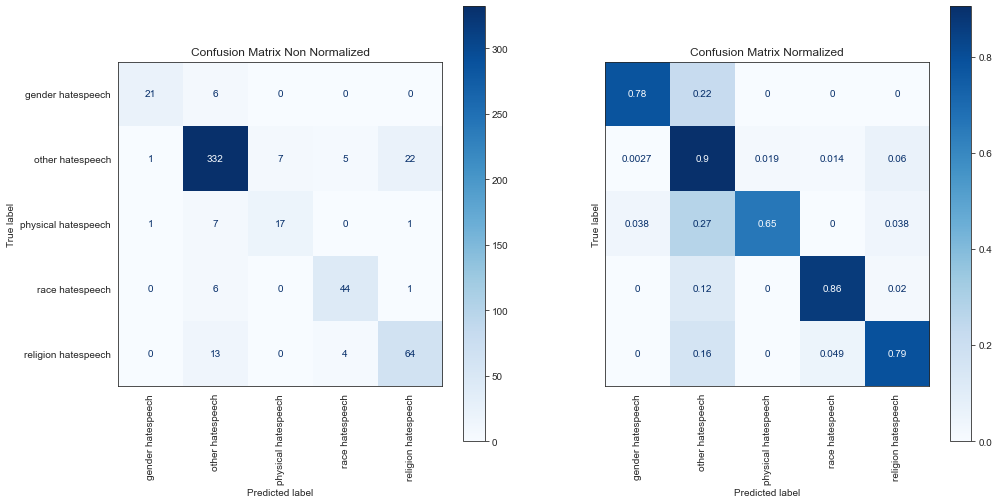

In [50]:
pipeline = ModelPipeline(RandomOverSampler(), TfidfVectorizer(max_features=4000, ngram_range=(1,1)), LabelEncoder(), XGBClassifier(max_depth=10, use_label_encoder=False, eval_metric='mlogloss'))
pipeline.fit(X_train, y_train)
pipelines["XGB"] = pipeline

y_pred = pipeline.predict(X_test)

print(pipeline.classification_report(y_test, y_pred))
pipeline.confusion_matrix_display(y_test, y_pred);

## Evaluasi

### Metrik
Metrik utama yang saya gunakan dalam melakukan evaluasi adalah precision dan recall, diikuti dengan f1-score dan accuracy. Hal ini dikarenakan diperlukan pengamatan yang agak mendetail terkait dengan kemampuan klasifikasi. Selain itu, metrik precision-recall dan f1-score juga baik untuk menilai data yang bersifat imbalance, dimana diketahui bahwa akurasi sangat lemah terhadap kondisi data imbalance. Data yang digunakan memiliki ketidakseimbangan, sehingga diharapkan dengan menggunakan metrik ini akan mendapat yang terbaik.

### Model Terbaik : XGBoost
Berdasarkan analisis nilai precision-recall dan f1-score, didapatkan Logistic Regression dan XGBoost memiliki performa test yang paling baik. Secara keseluruhan, XGBoost mendapatkan nilai f1-macro yang lebih baik sehingga menjadi model akhir terbaik.

In [54]:
print(pipelines["XGB"].classification_report(y_test, y_pred))

                     precision    recall  f1-score   support

  gender hatespeech       0.91      0.78      0.84        27
   other hatespeech       0.91      0.90      0.91       367
physical hatespeech       0.71      0.65      0.68        26
    race hatespeech       0.83      0.86      0.85        51
religion hatespeech       0.73      0.79      0.76        81

           accuracy                           0.87       552
          macro avg       0.82      0.80      0.81       552
       weighted avg       0.87      0.87      0.87       552



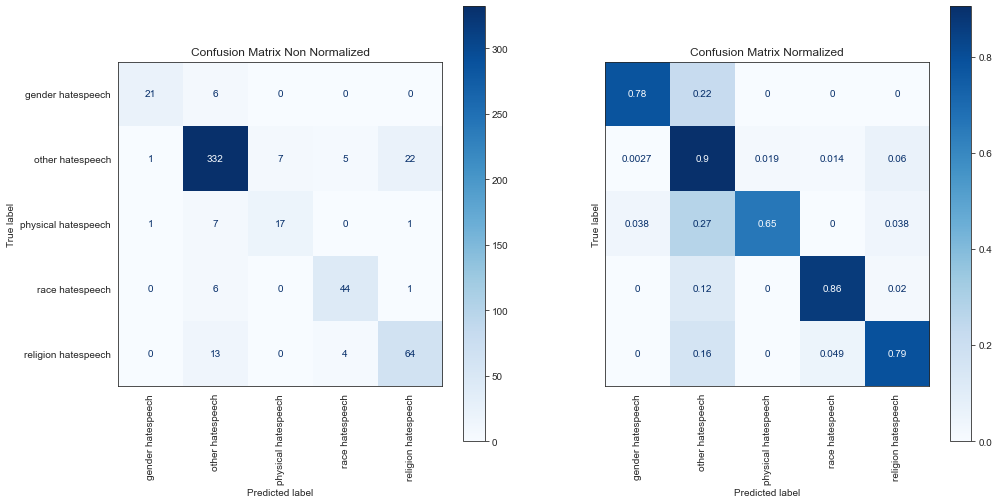

In [55]:
pipelines["XGB"].confusion_matrix_display(y_test, y_pred);

### Kesimpulan
Klasifikasi hate speech cukup berhasil dilakukan. Konfigurasi terbaik ditemukan dengan menggunakan TF-IDF sebagai representasi vektor kalimat, Undersampling untuk menangani imbalance, dan Basis kata dibanding menggunakan bigram. Ditemukan bahwa algoritma terbaik untuk kasus ini adalah XGBoost.

### Save Model

In [53]:
import dill

f = open("../model/hatespeech_topic.pkl", "wb")
dill.dump(pipelines["XGB"], f, recurse=True)
f.close()